# Regressão Linear

In [1]:
import sys
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
sys.path.append(os.path.abspath('..'))  # Adds the parent directory

from Lib import extract_from_data

df = pd.read_csv('../../Data/EV_Data.csv')
df.head()

,region,category,parameter,mode,powertrain,year,unit,value
0,Australia,Historical,EV sales,Cars,BEV,2011,Vehicles,49.00000
1,Australia,Historical,EV stock share,Cars,EV,2011,percent,0.00039
2,Australia,Historical,EV sales share,Cars,EV,2011,percent,0.00650
3,Australia,Historical,EV stock,Cars,BEV,2011,Vehicles,49.00000
4,Australia,Historical,EV stock,Cars,BEV,2012,Vehicles,220.00000


In [2]:
USA_Sales = extract_from_data(df, 'USA', ['EV sales'])
EU_Sales = extract_from_data(df, 'Europe', ['EV sales'])
China_Sales = extract_from_data(df, 'China', ['EV sales'])
Japan_Sales = extract_from_data(df, 'Japan', ['EV sales'])
Korea_Sales = extract_from_data(df, 'Korea', ['EV sales'])
India_Sales = extract_from_data(df, 'India', ['EV sales'])
Total_Sales = extract_from_data(df, 'World', ['EV sales'])

sales_pct_df = pd.DataFrame({
    'year': USA_Sales['year'],
    'USA_pct': USA_Sales['EV sales'] / Total_Sales['EV sales'],
    'Europe_pct': EU_Sales['EV sales'] / Total_Sales['EV sales'],
    'China_pct': China_Sales['EV sales'] / Total_Sales['EV sales'],
    'Japan_pct': Japan_Sales['EV sales'] / Total_Sales['EV sales'],
    'Korea_pct': Korea_Sales['EV sales'] / Total_Sales['EV sales'],
    'India_pct': India_Sales['EV sales'] / Total_Sales['EV sales'],
})
sales_pct_df

print("Checking the Sum!!")
print(sales_pct_df[['USA_pct', 'Europe_pct', 'China_pct', 'Japan_pct', 'Korea_pct', 'India_pct']].sum(axis=1, skipna=True))




Checking the Sum!!
0     0.988100
1     1.000306
2     0.973007
3     1.003681
4     0.973644
5     0.985108
6     0.976650
7     0.969290
8     0.951717
9     0.981014
10    0.975522
11    0.958862
12    0.967328
13    0.952518
dtype: float64


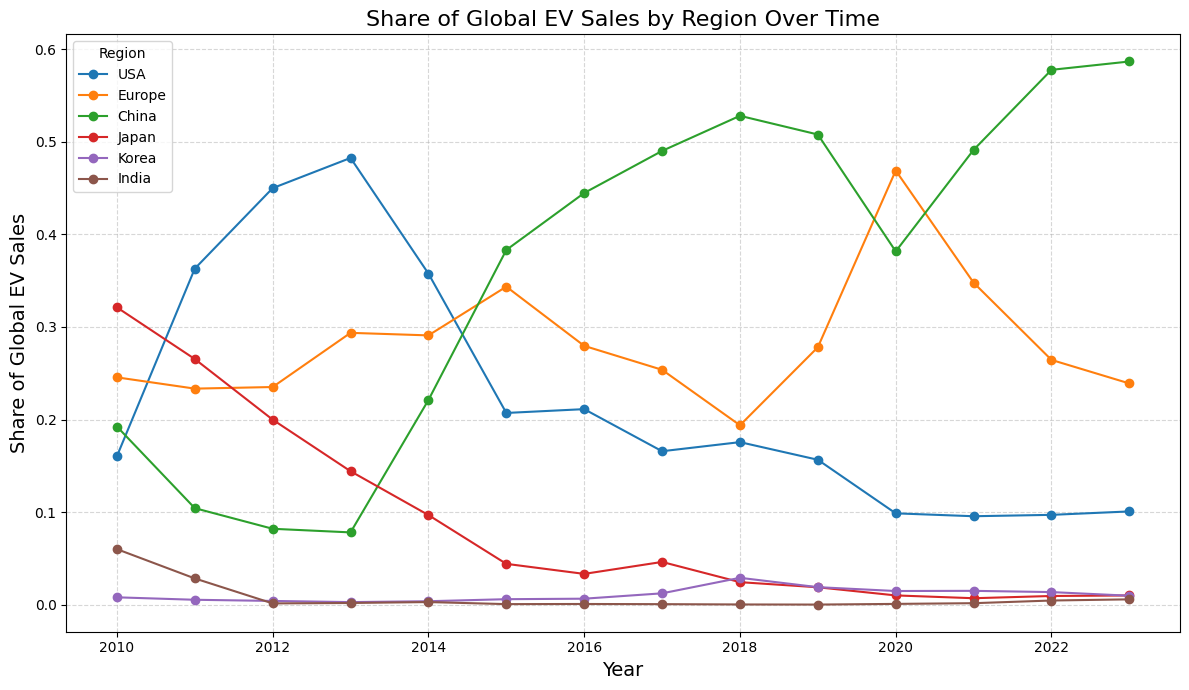

In [3]:
plt.figure(figsize=(12, 7))
for col in ['USA_pct', 'Europe_pct', 'China_pct', 'Japan_pct', 'Korea_pct', 'India_pct']:
    plt.plot(sales_pct_df['year'], sales_pct_df[col], marker='o', label=col.replace('_pct', ''))
plt.xlabel('Year', fontsize=14)
plt.ylabel('Share of Global EV Sales', fontsize=14)
plt.title('Share of Global EV Sales by Region Over Time', fontsize=16)
plt.legend(title='Region')
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


In [4]:
import pandas as pd
import numpy as np
from scipy.stats import ttest_rel
from statsmodels.stats.multitest import multipletests

# ─────────────────────────────────────────────────────────────────────────────
# 1) Get years and region columns
years = sales_pct_df['year'].sort_values().unique().tolist()
region_cols = [c for c in sales_pct_df.columns if c.endswith('_pct')]

# ─────────────────────────────────────────────────────────────────────────────
# 2) Run paired t‐test for each region separately, comparing each year to the previous year
rows = []

for region in region_cols:
    region_name = region.replace('_pct', '')
    
    for i in range(1, len(years)):
        current_year = years[i]
        previous_year = years[i-1]
        
        # Get values for this specific region for both years
        current_val = sales_pct_df.loc[sales_pct_df['year']==current_year, region].values[0]
        previous_val = sales_pct_df.loc[sales_pct_df['year']==previous_year, region].values[0]
        
        # Calculate percent change
        pct_change = ((current_val - previous_val) / previous_val) * 100 if previous_val != 0 else np.nan
        
        # For t-test, we need to create small samples around our values to perform the test
        # This is a statistical technique to handle single data points
        # We'll use a small variance (1% of the value) to create samples
        n_samples = 10
        
        if not np.isnan(pct_change) and previous_val != 0:
            # Create sample distributions around the actual values
            current_samples = np.random.normal(current_val, abs(current_val*0.01), n_samples)
            previous_samples = np.random.normal(previous_val, abs(previous_val*0.01), n_samples)
            
            # Run t-test
            t, p = ttest_rel(current_samples, previous_samples)
            
            # Determine if change is significant (using alpha = 0.05)
            reject_h0 = p < 0.05
            
            # Absolute percent change threshold (e.g., 20% change is significant)
            abs_pct_change = abs(pct_change)
            significant_change = abs_pct_change > 20  # Adjust threshold as needed
            
            # Combine statistical and practical significance
            reject = reject_h0 or significant_change
        else:
            t, p, reject = np.nan, np.nan, False
        
        rows.append({
            'region': region_name,
            'comparison': f"{previous_year}→{current_year}",
            'year': current_year,
            'previous_value': previous_val,
            'current_value': current_val,
            'absolute_change': current_val - previous_val,
            'percent_change': pct_change,
            't_stat': t,
            'p_value': p,
            'reject_H0': reject
        })

# Create DataFrame with all results
df_region_year = pd.DataFrame(rows)

# 3) Display results for Korea
korea_results = df_region_year[df_region_year['region'] == 'Korea'].sort_values('year')
print("Results for Korea:")
print(korea_results[['comparison', 'percent_change', 't_stat', 'p_value', 'reject_H0']])

# 4) Summary of all regions with significant changes
significant_changes = df_region_year[df_region_year['reject_H0']]
print(f"\nTotal significant changes detected: {len(significant_changes)}")
print(significant_changes[['region', 'comparison', 'percent_change', 'reject_H0']])

Results for Korea:
   comparison  percent_change      t_stat       p_value  reject_H0
52  2010→2011      -32.493637 -105.584578  3.111951e-15       True
53  2011→2012      -22.829848  -74.248451  7.375409e-14       True
54  2012→2013      -29.761465  -76.112192  5.902346e-14       True
55  2013→2014       31.962310   42.008032  1.224169e-11       True
56  2014→2015       55.797149   92.994671  9.747657e-15       True
57  2015→2016        8.767460   21.757123  4.315106e-09       True
58  2016→2017       86.686236  180.413617  2.511631e-17       True
59  2017→2018      134.475746  196.653577  1.156487e-17       True
60  2018→2019      -34.570746  -76.302718  5.771204e-14       True
61  2019→2020      -21.716951  -57.757943  7.040096e-13       True
62  2020→2021        1.218076    2.012352  7.504266e-02      False
63  2021→2022       -8.860107  -24.542860  1.483174e-09       True
64  2022→2023      -28.491770  -90.075820  1.298456e-14       True

Total significant changes detected: 76
   